In [2]:
# Using tf.keras for building an MNIST-MLP model
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD

# Using sckit-optimize for Bayesian optimization
!pip install scikit-optimize
import skopt


# Disabling stdout & using sys.stderr for printing
# This will throw away some keras messages and keep things tidy 
# when we run lots of models inside a loop
import sys
f = open('/dev/null', 'w')
sys.stdout = f
def eprint(*args, **kwargs):
  kwargs.pop('file', None)
  print(*args, file=sys.stderr, **kwargs)
  
  
# Load data once only
if not hasattr(sys.modules[__name__], 'LOADED_DATA'):
  eprint("Loading data...")
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  num_classes = 10
  x_train = x_train.reshape(60000, 784)
  x_test = x_test.reshape(10000, 784)
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)
  LOADED_DATA = True
  eprint("Done")
else:
  eprint("Data already loaded")

Data already loaded


# Bayesian Optimization for tuning ML Models

Below we define a function to build, train, and evaluate a Multi-layer perceptron (MLP) for the MNIST digit classification task.  The function takes several optional keyword arguments that control aspects of the training process and the model itself.  We refer to these values as **Hyperparameters**.

The default keyword arguments below construct a relatively small MLP, with just two hidden layers and 16 units per layer. The model is only trained for one epoch (or a single pass over the training data). 


In [0]:
def run_model(
   batch_size=128, 
   epochs=1, 
   nunits1=16,
   nunits2=16,
   dropout=0.1,
   activation='relu', 
   lr=0.01,
   momentum=0.0, 
  ):
  """
  Train MLP with 1 hidden layer on MNIST digit classification.
  Returns the minimization objective, which is (-1.0 * test_accuracy)
  """
  global x_train, x_test, y_train, y_test, num_classes
  model = Sequential()
  model.add(Dense(nunits1, activation=activation, input_shape=(784,)))
  model.add(Dropout(dropout))
  model.add(Dense(nunits2, activation=activation))
  model.add(Dropout(dropout))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=lr, clipnorm=1., momentum=momentum),
              metrics=['accuracy'])

  history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test, y_test))
  score = model.evaluate(x_test, y_test, verbose=0)
  return -1.0*score[1] # minimize -1.0*test_accuracy

In [90]:
objective = run_model()
eprint(f'Test Accuracy: {-1.0 * objective}')

Test Accuracy: 0.6406000256538391


## This model is pretty weak...

Clearly, we don't get a very competitive accuracy given the default parameters above. 

We want this demo to go fast, so let's keep the model small (16 units per hidden layer) and training very short (1 epoch).   Given those constraints, we can search for an optimal batch size and learning rate to improve the accuracy of our "budget" model.


s# Tuning Hyperparameters with Scikit-Optimizeitio

Let's focus on batch size and learning rate, while keeping other parameters fixed at their defaults.

We define the search space in Scikit optimize as a two-item list: one item for each search dimension.  Here, we construct an instance of skopt.Optimizer according to the tutorial at https://scikit-optimize.github.io/notebooks/ask-and-tell.html

After drawing `n_initial_points` at random, the search uses the ExtraTreesRegressor as a surrogate model of the model test accuracy.  This model is explicitly refit after each MNIST-MLP model evaluation in the loop below, on calls to `optimizer.tell()`.

In [0]:
problem_dimensions = [
    (6, 9),     # log2 (batch_size)
    (-3.0, 0.0), # log10 (learning rate)
]
def to_dict(x):
  return dict(batch_size=2**x[0], lr=10.0**x[1])

optimizer = skopt.Optimizer(
    problem_dimensions,
    "ET",
    acq_optimizer="sampling",
    n_initial_points=6,
)

In [95]:
eprint("Running Search")
N = 20
for i in range(N):
  next_x = optimizer.ask()
  eprint(f"[{i+1}/{N}]", to_dict(next_x))
  objective = run_model(**to_dict(next_x))
  optimizer.tell(next_x, objective)
  eprint(f"Accuracy: {-1.*objective}\n")

Running Search
[1/20] {'batch_size': 512, 'lr': 0.047511912158974566}
Accuracy: 0.7523999810218811

[2/20] {'batch_size': 256, 'lr': 0.009148879248701166}
Accuracy: 0.5924999713897705

[3/20] {'batch_size': 256, 'lr': 0.00113692219824057}
Accuracy: 0.21480000019073486

[4/20] {'batch_size': 256, 'lr': 0.0033343101661505283}
Accuracy: 0.1671999990940094

[5/20] {'batch_size': 256, 'lr': 0.010440698504632494}
Accuracy: 0.43970000743865967

[6/20] {'batch_size': 256, 'lr': 0.16706410838260416}
Accuracy: 0.8888999819755554

[7/20] {'batch_size': 256, 'lr': 0.002182792874242347}
Accuracy: 0.2824000120162964

[8/20] {'batch_size': 64, 'lr': 0.9291942203512946}
Accuracy: 0.8628000020980835

[9/20] {'batch_size': 64, 'lr': 0.10534239800691589}
Accuracy: 0.9038000106811523

[10/20] {'batch_size': 512, 'lr': 0.6420586880554402}
Accuracy: 0.869700014591217

[11/20] {'batch_size': 256, 'lr': 0.6889421897357594}
Accuracy: 0.8937000036239624

[12/20] {'batch_size': 128, 'lr': 0.6578672636795541}
Acc

# Visualizing Search Results

Let's take a look at the distribution of hyperparameters and model test accuracy as the hyperparameter search progressed.  The first scatterplot shows log2(batch_size) on the x-axis and log10(learning_rate) on the y-axis.  The points are color-coded from light-cyan to dark-blue in order of increasing iteration count.  Notice how the search quickly converges on the minimum batch size of 64  and larger learning rates in the range of 0.01 to 0.5.

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

def params_from_opt(optimizer):
  ndims = len(optimizer.Xi[0])
  return [ [x[i] for x in optimizer.Xi] for i in range(ndims) ]

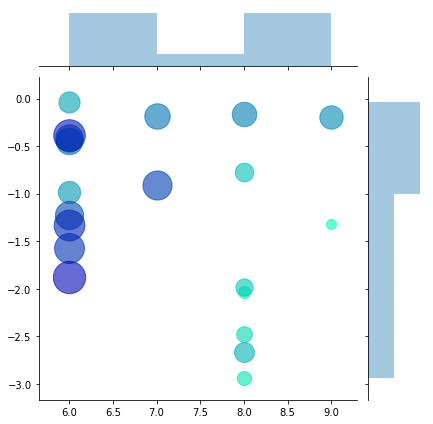

In [103]:
batch_sizes, learning_rates = params_from_opt(optimizer)
g = sns.jointplot(x=batch_sizes, y=learning_rates)
g.ax_joint.cla()
N = len(batch_sizes)
for i in range(N):
  g.ax_joint.scatter(batch_sizes[i], learning_rates[i], s=100+50*i, c=[(0.0, 0.99-i/N, 0.7, 0.6)])

## Model test accuracy

After running 6 random sets of hyperparamters, we draw points from the model.  Notice the behavior:
  - points 1 through 6 are drawn at random and have highly erratic accuracies ranging from under 20% to 90%
  - point 7 is the first sample drawn from the acquisition function; here, we also sample a relatively poor configuration as the algorithm is still "exploring" the hyperparameter space
  - Points 8 through 20 (corresponding to the dark blue points in scatterplot above) have consistently higher accuracy than the points initially drawn at random

Text(0, 0.5, 'Test Accuracy')

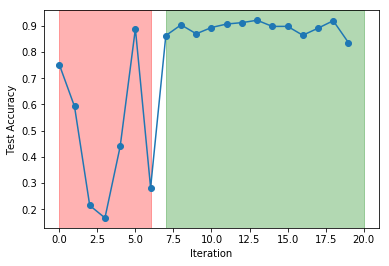

In [119]:
plt.plot(range(N), [-1.0*y for y in optimizer.yi], '-o')
plt.axvspan(0, 6, alpha=0.3, color='red')
plt.axvspan(7, 20, alpha=0.3, color='green')
plt.xlabel('Iteration')
plt.ylabel('Test Accuracy')